In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# other library
import numpy as np
import pandas as pd
import random
import os
from skimage import io

import importlib
import utils
importlib.reload(utils)
from utils import (
    ImgDataset, VAE, AE, 
    change_to_submit_format_df, output_to_csv, training
)

In [2]:
DATA_VIS_PATH = './visualization.npy'
MODEL_PATH = "./AE.pth"
DATA_PATH = './trainX.npy'

SEED = 5566
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
BATCH_SIZE = 256
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
])
data_vis = torch.from_numpy(
    np.load(DATA_VIS_PATH)
        ).float()
vis_dataset = ImgDataset(data_vis, transform)
vis_loader = DataLoader(vis_dataset,batch_size=BATCH_SIZE, shuffle=True)

In [4]:
img_channels = 3
latent_dim = 128
feature_dim = 2*2*256
best_AE = AE(
    img_channels, feature_dim, 
    latent_dim)
best_AE.load_state_dict(
    torch.load(MODEL_PATH)
)

<All keys matched successfully>

## Problem 2(a)

In [5]:
best_AE.to(device)
best_AE.eval()
for idx, img in enumerate(vis_loader):
    img = img.to(device, dtype=torch.float)
    out, img_latent = best_AE(img)
    break

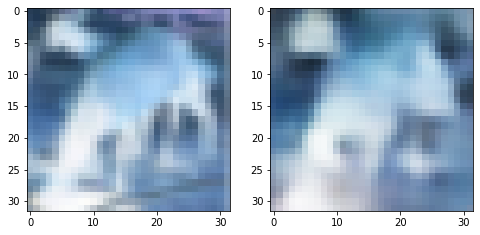

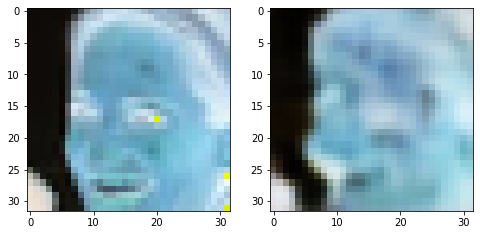

In [6]:
NUM_PIC = 2
display_pics = out[:NUM_PIC]
origin_pics = img[:2]
for i, pic in enumerate(display_pics):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()
    org_pic = origin_pics[i].cpu().detach().numpy()
    pic = pic.cpu().detach().numpy()
    pic = np.transpose(pic, (1, 2, 0))
    org_pic = np.transpose(org_pic, (1, 2, 0))
    ax[0].imshow(org_pic)
    ax[1].imshow(pic)
    io.show()

## Problem 2(b)

In [7]:
BATCH_SIZE = 256
transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor()
])
data_vis = torch.from_numpy(
    np.load(DATA_VIS_PATH)
        ).float()
vis_dataset = ImgDataset(data_vis, transform)
vis_loader = DataLoader(vis_dataset,batch_size=BATCH_SIZE, shuffle=False)

In [8]:
latent_space = []
best_AE.to(device)
best_AE.eval()
for idx, img in enumerate(vis_loader):
    img = img.to(device, dtype=torch.float)
    img_out, img_latent = best_AE(img)
    img_latent = img_latent.detach().cpu().numpy()
    for i in range(img_latent.shape[0]):
        latent_space.append(img_latent[i])
latent_space = np.asarray(latent_space)

In [9]:
#PCA -> TSNE -> KMeans
pca = PCA(n_components=45, copy=True, whiten=True, svd_solver='full', random_state = SEED)
latent_pca = pca.fit_transform(latent_space)

tsne = TSNE(random_state = SEED)
tsne_x = tsne.fit_transform(latent_pca)

result = KMeans(n_clusters=2, random_state = SEED, max_iter=1000).fit(tsne_x)

In [10]:
num_data = data_vis.shape[0]
x_0 = tsne_x[:num_data//2, 0]
y_0 = tsne_x[:num_data//2, 1]
x_1 = tsne_x[num_data//2:, 0]
y_1 = tsne_x[num_data//2:, 1]

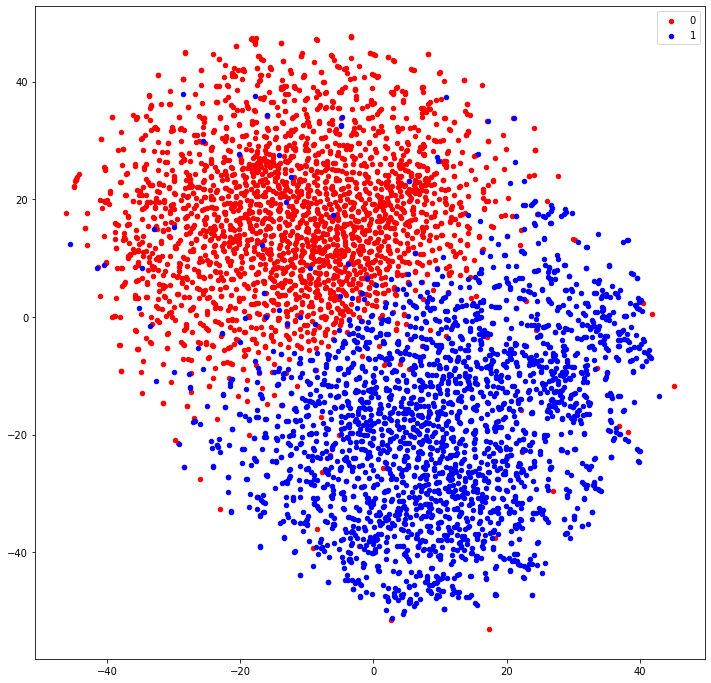

In [11]:
plt.figure(figsize=(12,12))
plt.scatter(x_0, y_0, s = 20, color = "red", label = "0")
plt.scatter(x_1, y_1, s = 20, color = "blue", label = "1")
plt.legend()
plt.show()

# Evaluation

In [12]:
correct_label = np.concatenate(
    [np.repeat(0, num_data//2), np.repeat(1, num_data//2)]
)
pred_result = KMeans(n_clusters=2, random_state = SEED, max_iter=1000).fit(tsne_x)
pred_label = 1 - pred_result.labels_

In [13]:
acc = (pred_label == correct_label).sum() / num_data
print(f"Accuracy of validation set is {round(acc*100, 4)}%")

Accuracy of validation set is 95.78%


In [14]:
idx_0 = (pred_result.labels_ == 0)
idx_1 = (pred_result.labels_ == 1)
x_0 = tsne_x[idx_0, 0]
y_0 = tsne_x[idx_0, 1]
x_1 = tsne_x[idx_1, 0]
y_1 = tsne_x[idx_1, 1]

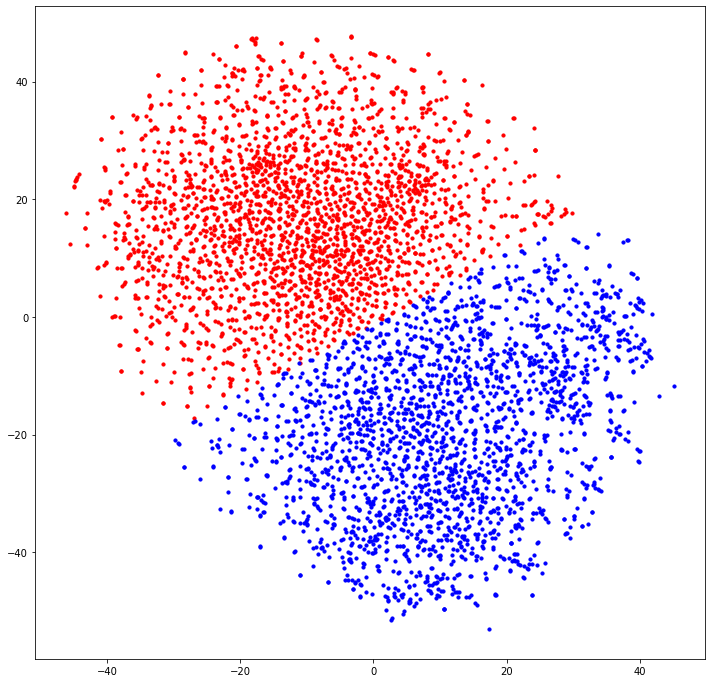

In [15]:
plt.figure(figsize=(12,12))
plt.scatter(x_1, y_1, s = 10, color = "red")
plt.scatter(x_0, y_0, s = 10, color = "blue")
plt.show()